In [26]:
import easyocr
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import json

# Detect point sur la feuille de marquage

In [27]:
def detect_point_column(image_path):
    # Lire l'image
    image = cv2.imread(image_path)

    # Convertir l'image en niveaux de gris
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Utiliser EasyOCR pour extraire le texte de l'image
    reader = easyocr.Reader(['fr'])  # Spécifiez la langue, par exemple 'fr' pour le français
    result = reader.readtext(gray)

    # Afficher le texte extrait (pour débogage)
    print("Texte extrait de l'image :")
    for (bbox, text, prob) in result:
        print(f"Texte: {text}, Probabilité: {prob}, Bounding box: {bbox}")
    return result

In [28]:
path = '.\data\externe\Belote-feuille de marquage.png'
# Remplacez 'feuillemarquage.png' et 'feuillemarquage.csv' par les chemins de vos fichiers
result = detect_point_column(path)

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Texte extrait de l'image :
Texte: Tour N, Probabilité: 0.992004546242548, Bounding box: [[47, 53], [91, 53], [91, 69], [47, 69]]
Texte: 162-0, Probabilité: 0.986716987636763, Bounding box: [[499, 93], [531, 93], [531, 105], [499, 105]]
Texte: 121-41, Probabilité: 0.9872908500721154, Bounding box: [[541, 93], [575, 93], [575, 105], [541, 105]]
Texte: Equipe, Probabilité: 0.9999611149061409, Bounding box: [[153, 97], [199, 97], [199, 115], [153, 115]]
Texte: Equipe, Probabilité: 0.9999386305040661, Bounding box: [[335, 99], [381, 99], [381, 115], [335, 115]]
Texte: 161-1, Probabilité: 0.9649814462069753, Bounding box: [[499, 109], [531, 109], [531, 121], [499, 121]]
Texte: 120-42, Probabilité: 0.9356685301298027, Bounding box: [[541, 109], [577, 109], [577, 121], [541, 121]]
Texte: Nom, Probabilité: 0.9997332370697246, Bounding box: [[185, 127], [217, 127], [217, 143], [185, 143]]
Texte: 160-2, Probabilité: 0.998876321429277, Bounding box: [[499, 125], [531, 125], [531, 137], [499, 137]]

# Visualisez les donnée

Texte: Tour N, Probabilité: 0.992004546242548, Bounding box: [[47, 53], [91, 53], [91, 69], [47, 69]]
Texte: 162-0, Probabilité: 0.986716987636763, Bounding box: [[499, 93], [531, 93], [531, 105], [499, 105]]
Texte: 121-41, Probabilité: 0.9872908500721154, Bounding box: [[541, 93], [575, 93], [575, 105], [541, 105]]
Texte: Equipe, Probabilité: 0.9999611149061409, Bounding box: [[153, 97], [199, 97], [199, 115], [153, 115]]
Texte: Equipe, Probabilité: 0.9999386305040661, Bounding box: [[335, 99], [381, 99], [381, 115], [335, 115]]
Texte: 161-1, Probabilité: 0.9649814462069753, Bounding box: [[499, 109], [531, 109], [531, 121], [499, 121]]
Texte: 120-42, Probabilité: 0.9356685301298027, Bounding box: [[541, 109], [577, 109], [577, 121], [541, 121]]
Texte: Nom, Probabilité: 0.9997332370697246, Bounding box: [[185, 127], [217, 127], [217, 143], [185, 143]]
Texte: 160-2, Probabilité: 0.998876321429277, Bounding box: [[499, 125], [531, 125], [531, 137], [499, 137]]
Texte: 119-43, Probabilité

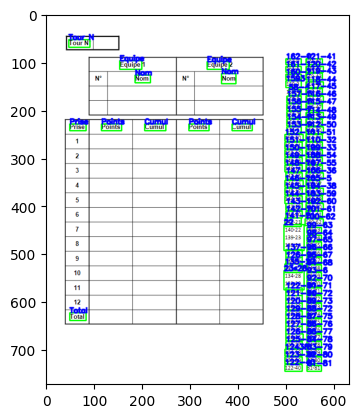

In [30]:
image = cv2.imread(path)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

for (bbox, text, prob) in result:
    print(f"Texte: {text}, Probabilité: {prob}, Bounding box: {bbox}")
    
    # Convertir les coordonnées en tuples d'entiers
    top_left = tuple(map(int, bbox[0]))
    bottom_right = tuple(map(int, bbox[2]))
    
    # Dessiner la bounding box sur l'image
    image = cv2.rectangle(image, top_left, bottom_right, (0, 255, 0), 2)
    image = cv2.putText(image, text, top_left, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2, cv2.LINE_AA)

# Afficher l'image avec les bounding boxes
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

# Decoupe l'images en cases

Nombre de contours détectés: 936
Nombre de contours: 20


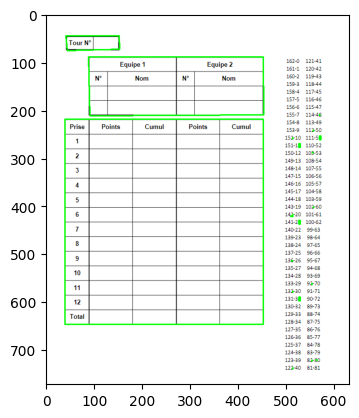

In [31]:
def detect_contours(frame, index, hierarhie, path):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edged = cv2.Canny(blurred, 30, 150)
    contours, hierarchy = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    print(f"Nombre de contours détectés: {len(contours)}")

    # Convertir les contours en une structure sérialisable
    contours_list = [contour.tolist() for contour in contours]
    hierarchy_list = hierarchy[0].tolist() if hierarchy is not None else []

    # Créer un dictionnaire pour stocker les contours et la hiérarchie
    data = {
        "contours": contours_list,
        "hierarchy": hierarchy_list
    }

    # Enregistrer dans un fichier JSON
    with open(path + f'_hierarchy_{index}.json', 'w') as json_file:
        json.dump(data, json_file, indent=4)

    # Afficher uniquement les trois premiers contours de la hiérarchie
    count = 0
    for i, contour in enumerate(contours):
        if count >= index:
            break
        if hierarchy[0][i][3] <= hierarhie:  # Vérifie si le contour est un contour de niveau supérieur
            peri = cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, 0.02 * peri, True)
            if len(approx) == 4:  # Vérifie si le contour est approximativement un rectangle
                cv2.drawContours(frame, [approx], -1, (0, 255, 0), 2)
                count += 1

                # Obtenir le rectangle englobant
                x, y, w, h = cv2.boundingRect(contour)
                # Découper la partie de l'image
                roi = frame[y:y+h, x:x+w]
                # Enregistrer la partie de l'image
                cv2.imwrite(path + f'_{x}_{y}_{h}_{w}.png', roi)
    
    print(f"Nombre de contours: {count}")
    return frame

# Construit le chemin complet de l'image
frame = cv2.imread(path)
path_sauvegarde = './data/externe/contours/'
frame_with_contours = detect_contours(frame, 200, 1, path_sauvegarde)
plt.imshow(cv2.cvtColor(frame_with_contours, cv2.COLOR_BGR2RGB))  # Applique la détection de contours
plt.show()
# cv2.imwrite('output.png', frame_with_contours)  # Sauvegarde l'image avec contours

## Repere ou sont les mots "point" sur la grande image

In [32]:
# Initialiser le compteur
compteur_detection = 0
mot_dection = 'Point'
mot_exclu =  ['Point Cumulée', 'Point Cumules']

# Initialiser la liste pour stocker les coordonnées des points
dection_points = []

for (bbox, text, prob) in result:
    if mot_dection in text.split(" ")[0] and prob > 0.5 and text not in mot_exclu:
        compteur_detection += 1
        # Transforme le bbox en tuple (x, y, w, h)
        bbox = (bbox[0][0], bbox[0][1], bbox[2][0] - bbox[0][0], bbox[2][1] - bbox[0][1])

        dection_points.append({'texte': text, 'bbox': bbox})

    if compteur_detection == 4:
        break

print(f"Nombre de points détectés: {compteur_detection}")
print("Coordonnées des points détectés:" + str(dection_points))

Nombre de points détectés: 2
Coordonnées des points détectés:[{'texte': 'Points', 'bbox': (115, 229, 42, 14)}, {'texte': 'Points', 'bbox': (297, 229, 42, 14)}]


## Repere ou sont les mots point sur la petite image

In [33]:
# Tolérance pour la comparaison des coordonnées
tolerance_x = 50
tolerance_y = 20
tolerance_w = 5
tolerance_h = 80

list_points = []

# Fonction pour extraire les coordonnées du nom de fichier
def extraire_coordonnees(nom_fichier):
    try:
        # Enlever l'extension du fichier
        nom_fichier_sans_extension = os.path.splitext(nom_fichier)[0]
        # Supposer que le nom de fichier est de la forme _x_y_w_h
        _, x, y, w, h = nom_fichier_sans_extension.split('_')
        return int(x), int(y), int(w), int(h)
    except ValueError:
        return None

# Fonction pour comparer les coordonnées avec tolérance
def comparer_coordonnees(coord1, coord2, tol_x, tol_y, tol_w, tol_h):
    x1, y1, w1, h1 = coord1
    x2, y2, w2, h2 = coord2
    return (abs(x1 - x2) <= tol_x and
            abs(y1 - y2) <= tol_y and
            abs(w1 - w2) <= tol_w and
            abs(h1 - h2) <= tol_h)

# Parcourir les fichiers dans le répertoire
for file in os.listdir(path_sauvegarde):
    if file.endswith('.png'):
        # Extraire les coordonnées du nom de fichier
        coordonnees = extraire_coordonnees(file)
        if coordonnees:
            # Comparer les coordonnées extraites avec celles des points détectés
            for point in dection_points:
                if comparer_coordonnees(point['bbox'], coordonnees, tolerance_x, tolerance_y, tolerance_w, tolerance_h):
                    list_points.append({'texte': point['texte'], 'position': coordonnees, 'image': file})
                    break  # Sortir de la boucle dès qu'un point est trouvé

print(list_points)

[]


## Verification des petites images pour les points

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Texte extrait de l'image :
Texte: Point, Probabilité: 0.9997250654772647, Bounding box: [[29, 13], [59, 13], [59, 25], [29, 25]]


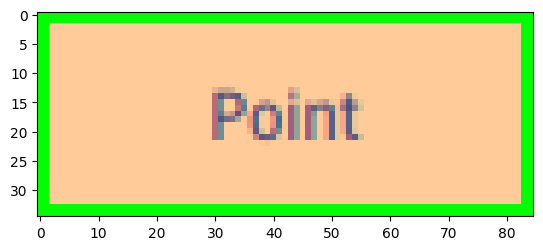

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


[{'texte': 'Point', 'position': (122, 140, 35, 85), 'image': '_122_140_35_85.png'}]
Texte extrait de l'image :
Texte: Point, Probabilité: 0.9992898008748511, Bounding box: [[29, 13], [59, 13], [59, 25], [29, 25]]


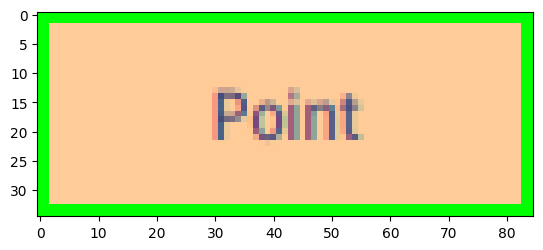

[{'texte': 'Point', 'position': (122, 140, 35, 85), 'image': '_122_140_35_85.png'}, {'texte': 'Point', 'position': (298, 140, 35, 85), 'image': '_298_140_35_85.png'}]


In [22]:
check_header_points = []
# Afficher les images correspondantes
for point in list_points:
    chemin_image = os.path.join(path_sauvegarde, point['image'])
    image_lue = cv2.imread(chemin_image)
    
    # Vérifier si l'image a été correctement lue
    if image_lue is None:
        print(f"Erreur : Impossible de lire le fichier {chemin_image}.")
        continue

    verify_result= detect_point_column(chemin_image)
    for (bbox, text, prob) in verify_result:
        if mot_dection in text.split(" ")[0] and prob > 0.5 and text not in mot_exclu:
            check_header_points.append(point)
    
    
    plt.imshow(cv2.cvtColor(image_lue, cv2.COLOR_BGR2RGB))
    plt.show()
    print(check_header_points)

## Recupérer les images en desous des headers_points

In [23]:
image_points= []

for file in os.listdir(path_sauvegarde):
    if file.endswith('.png'):
        # Extraire les coordonnées du nom de fichier
        coordonnees = extraire_coordonnees(file)
        if coordonnees:
            # Comparer les coordonnées extraites avec celles des points détectés
            for point in check_header_points:
                if point["position"][0] == coordonnees[0] and point["position"] != coordonnees and point["position"][1] < coordonnees[1]:
                    image_points.append({'texte': "", 'position': coordonnees, 'image': file})
                    break

print(image_points)
print(len(image_points))

[{'texte': '', 'position': (122, 178, 29, 85), 'image': '_122_178_29_85.png'}, {'texte': '', 'position': (122, 209, 29, 85), 'image': '_122_209_29_85.png'}, {'texte': '', 'position': (122, 240, 30, 85), 'image': '_122_240_30_85.png'}, {'texte': '', 'position': (122, 272, 29, 85), 'image': '_122_272_29_85.png'}, {'texte': '', 'position': (122, 303, 29, 85), 'image': '_122_303_29_85.png'}, {'texte': '', 'position': (122, 334, 30, 85), 'image': '_122_334_30_85.png'}, {'texte': '', 'position': (122, 366, 29, 85), 'image': '_122_366_29_85.png'}, {'texte': '', 'position': (122, 397, 29, 85), 'image': '_122_397_29_85.png'}, {'texte': '', 'position': (122, 428, 30, 85), 'image': '_122_428_30_85.png'}, {'texte': '', 'position': (122, 460, 29, 85), 'image': '_122_460_29_85.png'}, {'texte': '', 'position': (122, 491, 30, 85), 'image': '_122_491_30_85.png'}, {'texte': '', 'position': (122, 523, 29, 85), 'image': '_122_523_29_85.png'}, {'texte': '', 'position': (122, 554, 31, 85), 'image': '_122_55

In [24]:
# Deplace les images dans un dossier

path_images_point= os.path.join(path_sauvegarde, 'points')
if not os.path.exists(path_images_point):
    os.makedirs(path_images_point)

for point in image_points:
    chemin_image = os.path.join(path_sauvegarde, point['image'])
    os.replace(chemin_image, os.path.join(path_images_point, point['image']))